### **Census tract data exploratory data analysis**

In [63]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

#### Load data files saved from API

In [3]:
# collect parquet files
output_file = "../census_outputs/census_tract_2020.parquet/"

parq_files = [ os.path.join(output_file, file) for file in os.listdir(output_file) if ".parquet" in file ]

parq_files.sort()

census_tract_df = dd.concat([ dd.read_parquet(file) for file in parq_files ])

In [4]:
# show first 5 rows of first partition
census_tract_df.head()

,geo_id,state_code,state_name,county,tract,tract_name,variable_code,variable_name,value,measurement,demographic_target,demographic
0,1400000US01073003600,01,Alabama,073,003600,"Census Tract 36, Jefferson County, Alabama",DP02_0001E,Estimate!!HOUSEHOLDS BY TYPE!!Total households,2019,estimate,households by type,total households
1,1400000US01073003600,01,Alabama,073,003600,"Census Tract 36, Jefferson County, Alabama",DP02_0001EA,Annotation of Estimate!!HOUSEHOLDS BY TYPE!!To...,0,annotation of estimate,households by type,total households
2,1400000US01073003600,01,Alabama,073,003600,"Census Tract 36, Jefferson County, Alabama",DP02_0001M,Margin of Error!!HOUSEHOLDS BY TYPE!!Total hou...,408,margin of error,households by type,total households
3,1400000US01073003600,01,Alabama,073,003600,"Census Tract 36, Jefferson County, Alabama",DP02_0001MA,Annotation of Margin of Error!!HOUSEHOLDS BY T...,0,annotation of margin of error,households by type,total households
4,1400000US01073003600,01,Alabama,073,003600,"Census Tract 36, Jefferson County, Alabama",DP02_0001PE,Percent!!HOUSEHOLDS BY TYPE!!Total households,2019,percent,households by type,total households


In [5]:
# show number of partitions
census_tract_df.npartitions

991

In [6]:
# get shape of dataframe (rows, columns)

census_tract_df_shape = census_tract_df.shape
print("Dataframe shape:", (census_tract_df_shape[0].compute(), census_tract_df_shape[1]))

Dataframe shape: (103998048, 12)


In [7]:
# show column names
census_tract_df.columns

Index(['geo_id', 'state_code', 'state_name', 'county', 'tract', 'tract_name',
       'variable_code', 'variable_name', 'value', 'measurement',
       'demographic_target', 'demographic'],
      dtype='object')

In [8]:
# Get information about DataFrame
# info includes types of columns, count non-nul, &count null
info_dict = {"dtypes": census_tract_df.dtypes, "non null rows": census_tract_df.notnull().sum().compute(), "null rows": census_tract_df.isna().sum().compute()} 

info_df = pd.DataFrame(info_dict).reset_index().rename({"index": "column"})

info_df

,index,dtypes,non null rows,null rows
0,county,string[pyarrow],103998048,0
1,demographic,string[pyarrow],103998048,0
2,demographic_target,string[pyarrow],103998048,0
3,geo_id,string[pyarrow],103998048,0
4,measurement,string[pyarrow],103998048,0
5,state_code,string[pyarrow],103998048,0
6,state_name,string[pyarrow],103998048,0
7,tract,string[pyarrow],103998048,0
8,tract_name,string[pyarrow],103998048,0
9,value,string[pyarrow],103998048,0


#### Find the number of census tracts for each state

In [9]:
# list number of unique states
len(census_tract_df.state_code.unique())

51

In [10]:
# census tract count by state

# make tracts unique
dupe_tracts = census_tract_df.drop_duplicates(subset=["state_code", "tract"])

state_tract_count = dupe_tracts.groupby("state_name").size().reset_index().rename(columns = {0: "n"}).sort_values("n", ascending = False).compute()

state_tract_count.reset_index(drop=True).head()

,state_name,n
0,California,7369
1,Texas,5136
2,Florida,3712
3,New York,3167
4,Illinois,2730


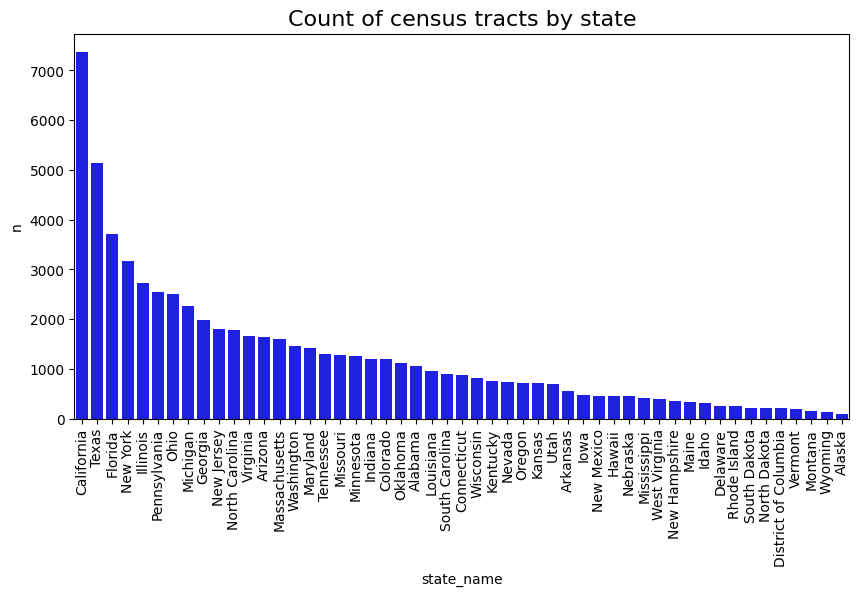

In [39]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.xticks(rotation = 90)

plt.title("Count of census tracts by state", fontsize = 16)

sns.barplot(data = state_tract_count, x= "state_name", y= "n", color= "b")

plt.show()

#### Clean "value" column to have only positive numeric values

In [12]:
# find non integer values & replace with 0
census_tract_df["value"] = dd.to_numeric(census_tract_df["value"].astype(str), errors='coerce').fillna(0).astype(float)

In [13]:
# remove rows with zero or negative values
census_tract_df = census_tract_df.loc[census_tract_df["value"] > 0]

#### Summarize variable values for each census tract

In [14]:
def census_tract_summ(group_vars, df = census_tract_df):
    df_grouped = df.groupby(group_vars).agg({"value": ["mean", "std", "count", "min", "max"]}).compute()

    df_grouped.columns = df_grouped.columns.droplevel(0)

    df_grouped = df_grouped.reset_index().sort_values(group_vars)

    return df_grouped

In [15]:
# statistical measure of each variable value by state
state_describe_df = census_tract_summ(["state_name", "variable_name", "variable_code"])

In [16]:
state_describe_df.head()

,state_name,variable_name,variable_code,mean,std,count,min,max
403,Alabama,Estimate!!ANCESTRY!!Total population,DP02_0124E,3419.417191,1407.753256,1431,7.0,11493.0
406,Alabama,Estimate!!ANCESTRY!!Total population!!American,DP02_0125E,555.105263,447.656951,1425,1.0,3189.0
535,Alabama,Estimate!!ANCESTRY!!Total population!!Arab,DP02_0126E,40.609121,73.562056,307,1.0,715.0
552,Alabama,Estimate!!ANCESTRY!!Total population!!Czech,DP02_0127E,19.757709,30.016491,227,1.0,339.0
537,Alabama,Estimate!!ANCESTRY!!Total population!!Danish,DP02_0128E,18.421277,22.296113,235,1.0,204.0


#### Summarize variable values for all states

In [17]:
# statistical measure of each variable value for all states
us_describe_df = census_tract_summ(["variable_name", "variable_code"])

# set state_name column as "USA"
us_describe_df.loc[:, "state_name"] = "USA"

In [18]:
us_describe_df.head()

,variable_name,variable_code,mean,std,count,min,max,state_name
403,Estimate!!ANCESTRY!!Total population,DP02_0124E,3906.424891,1633.866307,83598,1.0,39373.0,USA
406,Estimate!!ANCESTRY!!Total population!!American,DP02_0125E,237.774322,258.725708,81439,1.0,8644.0,USA
535,Estimate!!ANCESTRY!!Total population!!Arab,DP02_0126E,57.715994,113.625668,35633,1.0,4745.0,USA
552,Estimate!!ANCESTRY!!Total population!!Czech,DP02_0127E,36.066699,55.089663,36852,1.0,1552.0,USA
537,Estimate!!ANCESTRY!!Total population!!Danish,DP02_0128E,36.026459,54.060951,34544,1.0,1799.0,USA


#### Visualize each average state values to the average US value for given variables

In [42]:
def plot_us_state_mean(code, title, state_summ = state_describe_df, us_summ = us_describe_df):
    state_variable_summ = state_summ[state_summ["variable_code"] == code]

    us_variable_summ = us_summ[us_summ["variable_code"] == code]

    plot_summ_df = pd.concat([state_variable_summ, us_variable_summ]).sort_values("mean", ascending = False)

    fig, ax = plt.subplots(figsize = (12, 6))

    sns.barplot(plot_summ_df, x = "state_name", y = "mean", palette = [ "b" if x != "USA" else "r" for x in plot_summ_df["state_name"] ])

    plt.xticks(rotation=90)

    plt.title(title, fontsize = 16)

    plt.show()

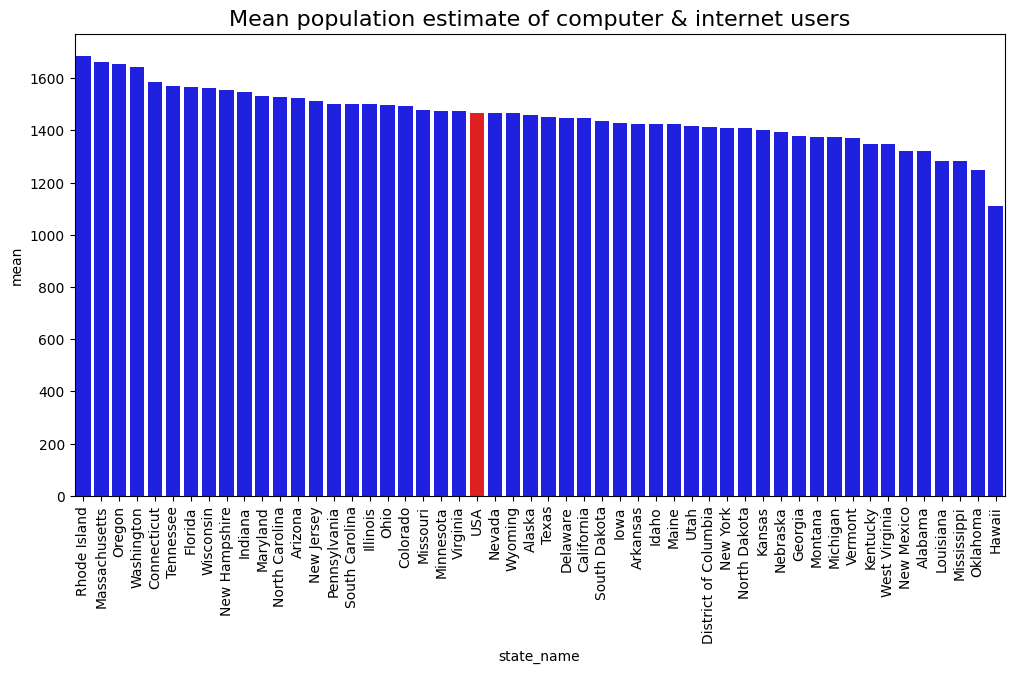

In [43]:
# Estimate!!COMPUTERS AND INTERNET USE!!Total households	
internet_summ = plot_us_state_mean(
    "DP02_0152E",
    "Mean population estimate of computer & internet users"
    )

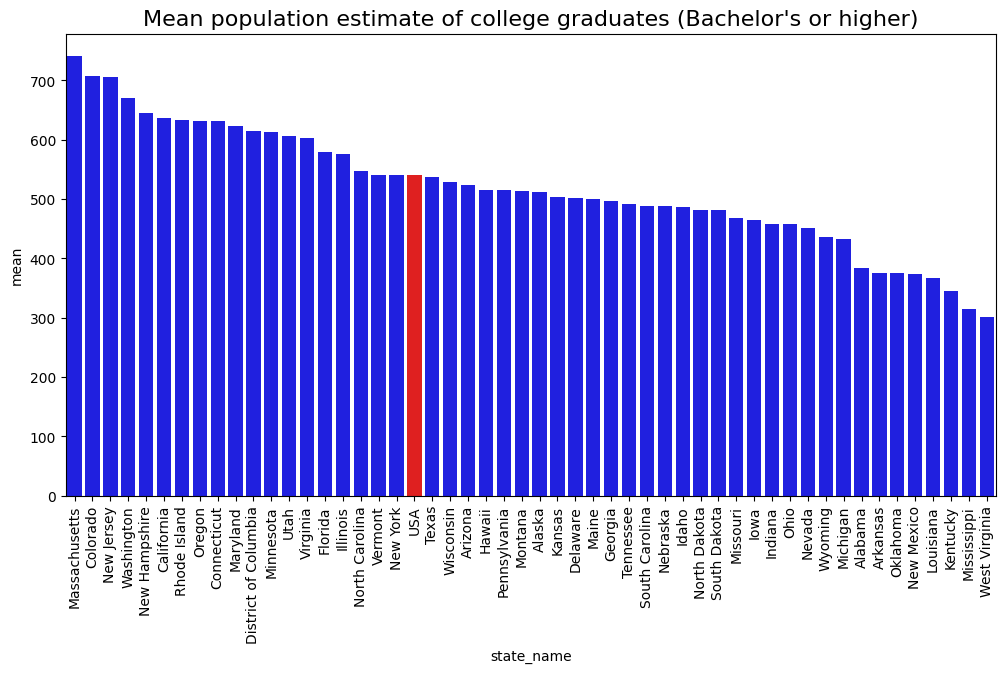

In [44]:
# Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree
bach_grad_summ = plot_us_state_mean(
    "DP02_0065E",
    "Mean population estimate of college graduates (Bachelor's or higher)"
    )

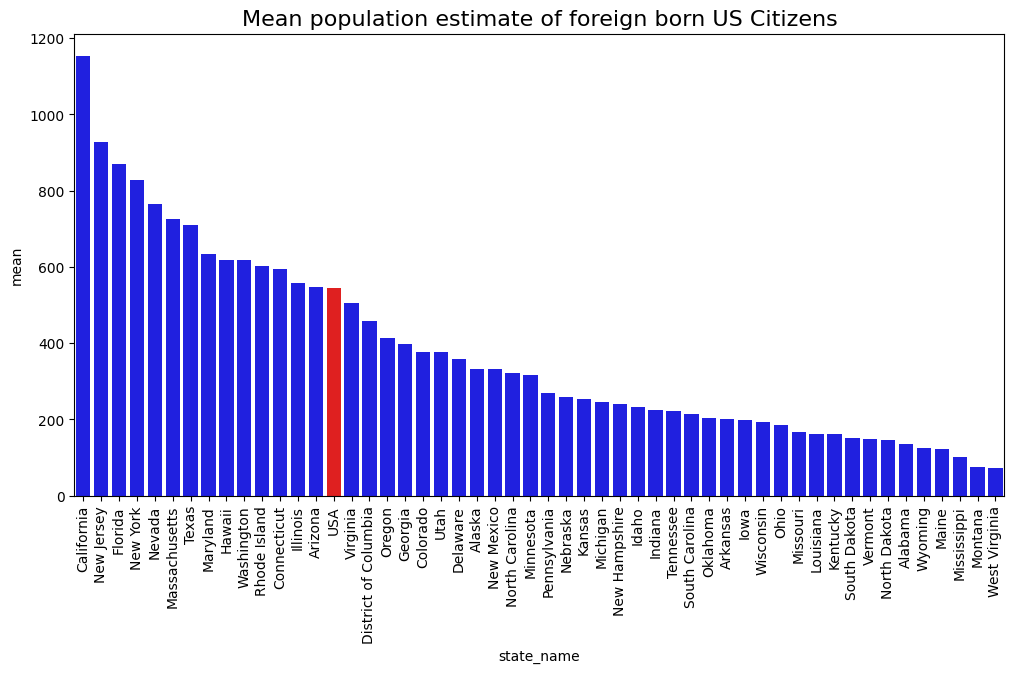

In [45]:
# Estimate!!U.S. CITIZENSHIP STATUS!!Foreign-born population
foreign_born_summ = plot_us_state_mean(
    "DP02_0095E",
    "Mean population estimate of foreign born US Citizens"
    )

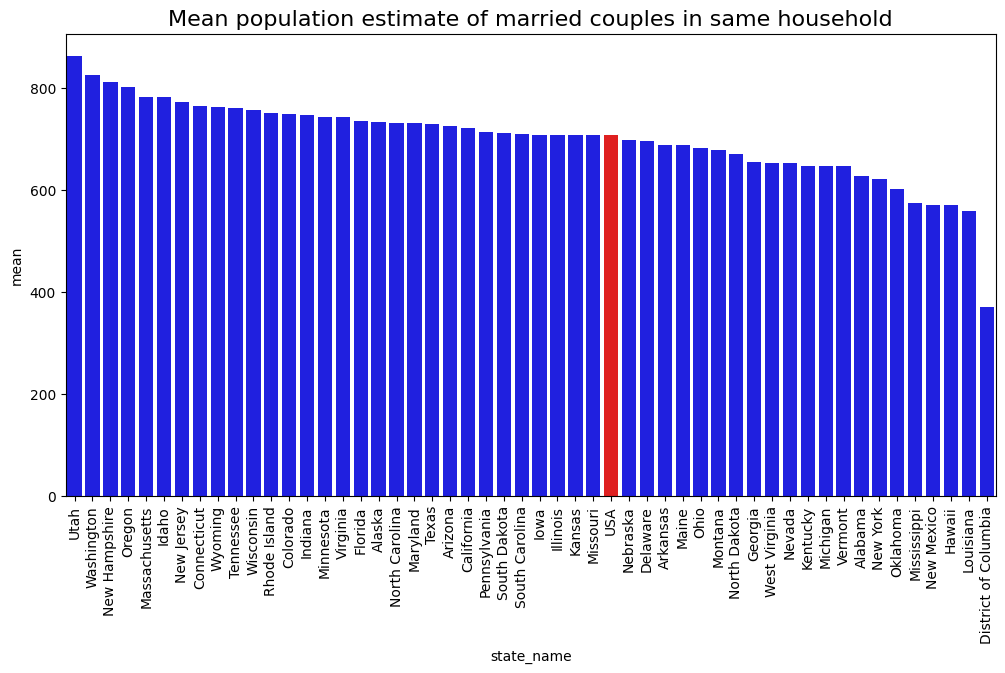

In [46]:
# Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Married-couple household
marriage_summ = plot_us_state_mean(
    "DP02_0002E",
    "Mean population estimate of married couples in same household"
    )

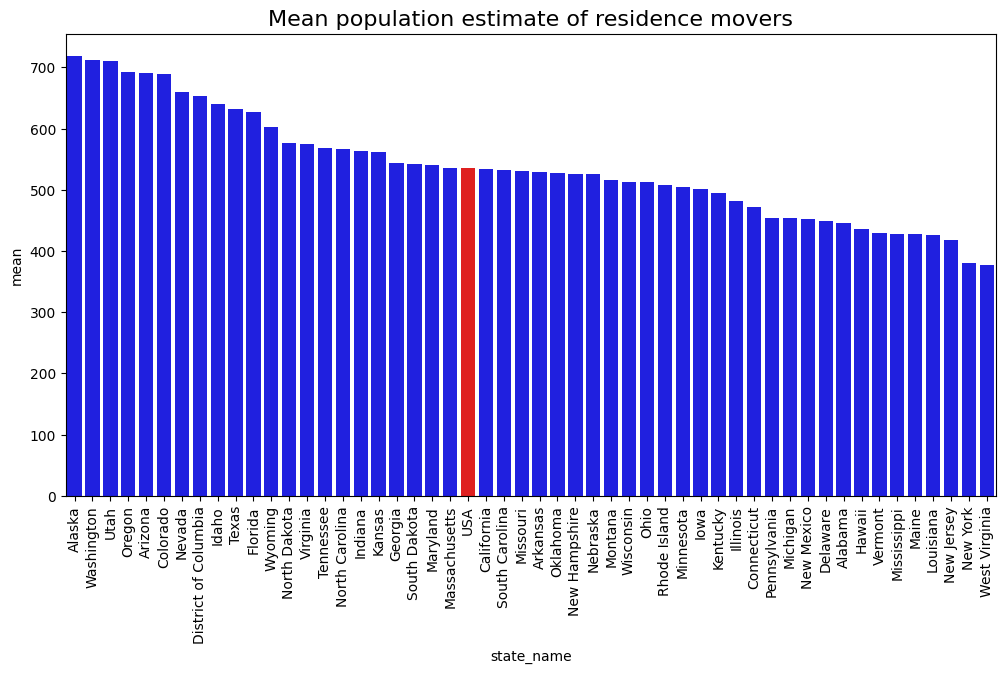

In [47]:
# Estimate!!RESIDENCE 1 YEAR AGO!!Population 1 year and over!!Different house (in the U.S. or abroad)
movers_summ = plot_us_state_mean(
    "DP02_0081E",
    "Mean population estimate of residence movers"
    )

In [25]:
# look more into:
#  - college grads (DP02_0065E)
#  - computer/internet users (DP02_0152E)

#### Plot relationship between educational attainment & internet yse

In [26]:
# create scatter plot fo two given variables
def scatter_mean_variables(var_code1, var_title1, var_code2, var_title2):
    df_var_code1 = state_describe_df[state_describe_df.loc[: , "variable_code"] == var_code1]
    df_var_code2 = state_describe_df[state_describe_df.loc[: , "variable_code"] == var_code2]

    var_code1_name = f"{var_title1}_mean"
    var_code2_name = f"{var_title2}_mean"

    var_code1_mean = df_var_code1.loc[:, ["state_name", "mean"]].rename({"mean": var_code1_name}, axis = 1)
    var_code2_mean = df_var_code2.loc[:, ["state_name", "mean"]].rename({"mean": var_code2_name}, axis = 1)

    var_codes_mean = var_code1_mean.merge(var_code2_mean, on = "state_name", how = "left")

    fig, ax = plt.subplots(figsize = (8, 5))

    sns.regplot(data=var_codes_mean, x=var_code1_name, y=var_code2_name, color = "b")

    plt.title(f"Relationship between {var_code1_name} & {var_code2_name}", fontsize = 12)

    plt.show()


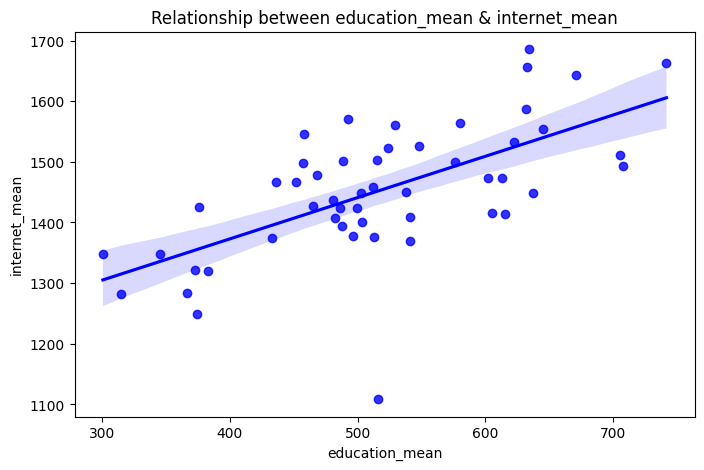

In [27]:
scatter_mean_variables("DP02_0065E", "education", "DP02_0152E", "internet")

In [28]:
census_tract_education = census_tract_df[census_tract_df.loc[: , "variable_code"] == "DP02_0065E"].compute()

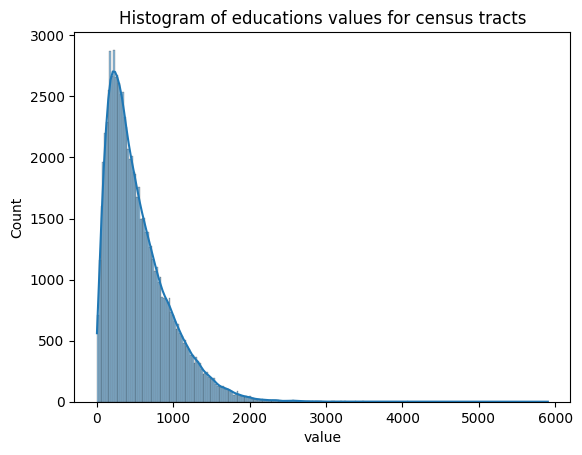

In [29]:
sns.histplot(data=census_tract_education, x="value", kde=True)
plt.title(f"Histogram of educations values for census tracts", fontsize = 12)

plt.show()

In [30]:
census_tract_education.value.describe()

count    83369.000000
mean       540.184121
std        408.463753
min          1.000000
25%        235.000000
50%        435.000000
75%        747.000000
max       5903.000000
Name: value, dtype: float64

In [31]:
census_tract_internet = census_tract_df[census_tract_df.loc[: , "variable_code"] == "DP02_0152E"].compute()

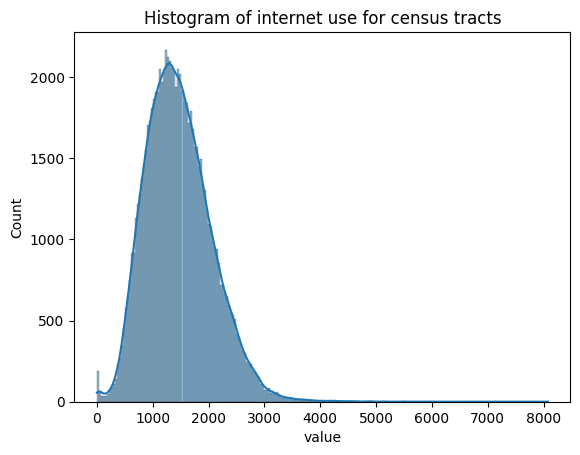

In [32]:
sns.histplot(data=census_tract_internet, x="value", kde=True)
plt.title(f"Histogram of internet use for census tracts", fontsize = 12)

plt.show()

In [33]:
census_tract_internet.value.describe()

count    83351.000000
mean      1467.939425
std        592.853653
min          1.000000
25%       1042.000000
50%       1412.000000
75%       1831.000000
max       8078.000000
Name: value, dtype: float64

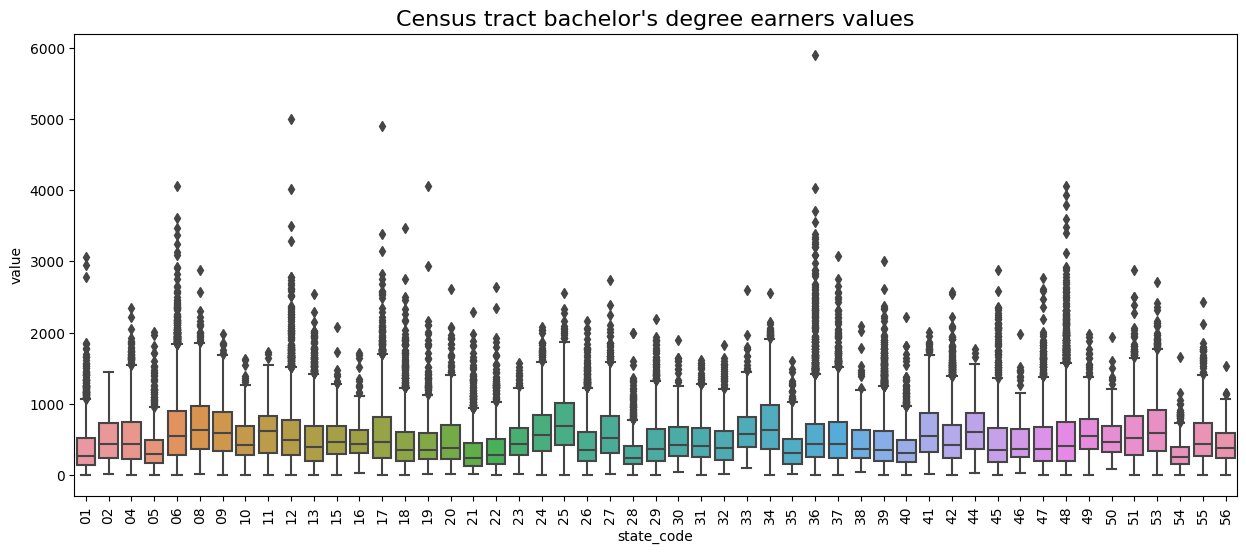

In [56]:
# box plot to see outliers

education_sort = census_tract_education.sort_values("state_code")

fig, ax = plt.subplots(figsize = (15, 6))

sns.boxplot(data = education_sort, x = "state_code", y = "value")

plt.xticks(rotation=90)

plt.title("Census tract bachelor's degree earners values", fontsize = 16)

plt.show()

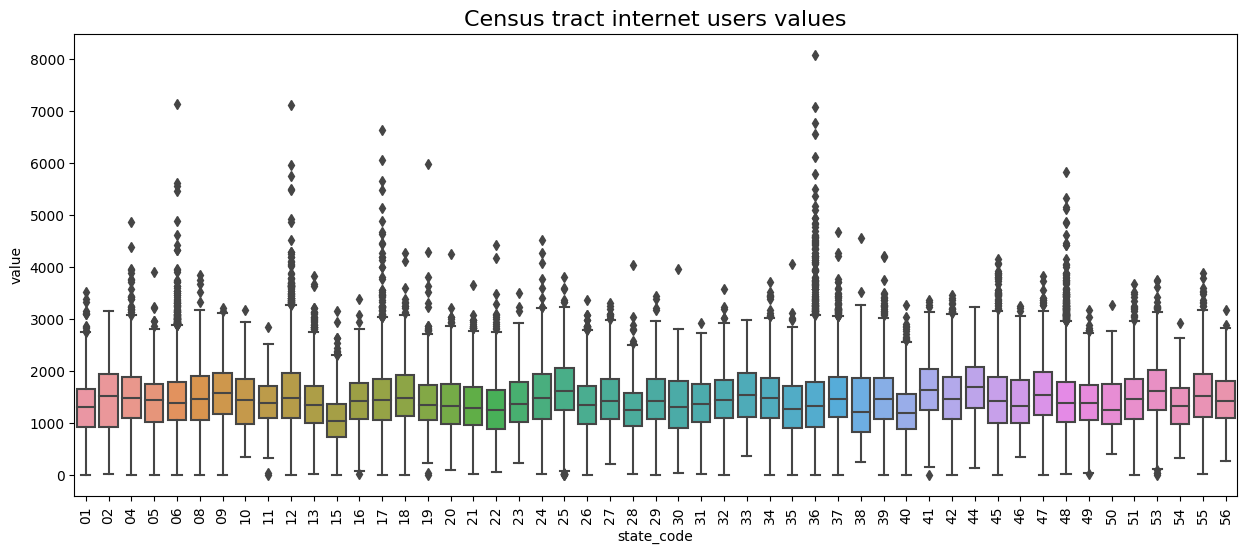

In [57]:
internet_sort = census_tract_internet.sort_values("state_code")

fig, ax = plt.subplots(figsize = (15, 6))

sns.boxplot(data = internet_sort, x = "state_code", y = "value")

plt.xticks(rotation=90)

plt.title("Census tract internet users values", fontsize = 16)

plt.show()

In [66]:
# cap values by three standard deviations

education_ul = np.mean(census_tract_education["value"]) + (3 * np.std(census_tract_education["value"]))
education_ll = np.mean(census_tract_education["value"]) - (3 * np.std(census_tract_education["value"]))

print("Education upper limit:", education_ul)
print("Education lower limit:", education_ll)

Education upper limit: 1765.5680320909278
Education lower limit: -685.1997896986717


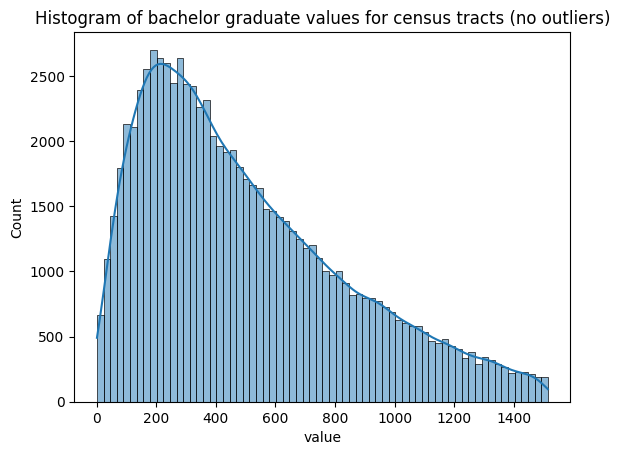

In [82]:
education_no_outlier = census_tract_education[ (census_tract_education["value"] < education_ul) & (census_tract_education["value"] > education_ll) ]

sns.histplot(data = education_no_outlier, x = "value", kde = True)
plt.title(f"Histogram of bachelor graduate values for census tracts (no outliers)", fontsize = 12)

plt.show()

In [80]:
internet_ul = np.mean(census_tract_internet["value"]) + (3 * np.std(census_tract_internet["value"]))
internet_ll = np.mean(census_tract_internet["value"]) - (3 * np.std(census_tract_internet["value"]))

print("Education upper limit:", internet_ul)
print("Education lower limit:", internet_ll)

Education upper limit: 3246.4897158181807
Education lower limit: -310.6108661343137


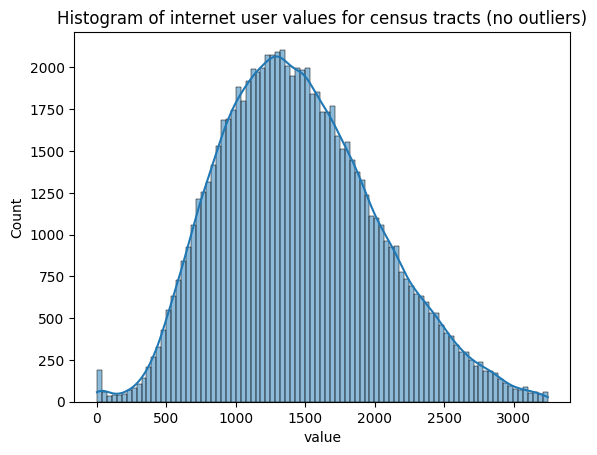

In [81]:
internet_no_outlier = census_tract_internet[ (census_tract_internet["value"] < internet_ul) & (census_tract_internet["value"] > internet_ll) ]

sns.histplot(data = internet_no_outlier, x = "value", kde = True)
plt.title(f"Histogram of internet user values for census tracts (no outliers)", fontsize = 12)

plt.show()